# **Mô hình KNN**

## **Import thư viện cần thiết**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_error


## **Đọc dữ liệu**

In [2]:
df = pd.read_csv("../../data/data_processed/data_processed.csv")
df.head()

,LB,AC,FM,UC,DL,DS,DP,ASTV,MSTV,ALTV,...,Min,Max,Nmax,Nzeros,Mode,Mean,Median,Variance,Tendency,NSP
0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,4.0,0.0,4.0,2.0,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,2.0,0.0,5.0,2.0,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,2.0,0.0,6.0,2.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,4.0,0.0,5.0,0.0,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


In [3]:
# Tách đặc trưng và nhãn
X = df.drop(columns=["NSP"]).values
# Nhãn
y = df["NSP"].values 

# Chuẩn hóa đặc trưng
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Mô hình KNN**

Giá trị k tối ưu: 7
Giá trị MSE tốt nhất (trung bình cross-val): 0.1656


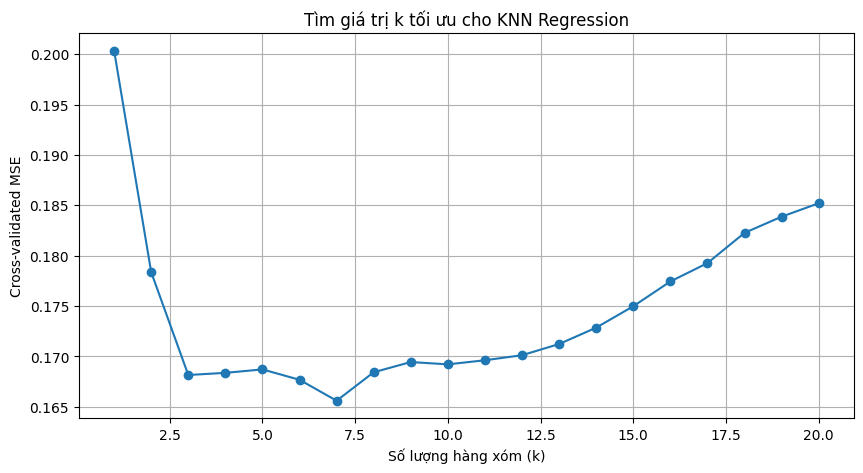

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import make_scorer, mean_squared_error

# Hàm đánh giá là MSE nên ta dùng neg_mean_squared_error (để GridSearchCV tối đa hóa)
scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Khởi tạo mô hình
knn = KNeighborsRegressor()

# Tập giá trị k cần thử
param_grid = {"n_neighbors": list(range(1, 21))}

# GridSearchCV với 5-fold cross-validation
grid = GridSearchCV(knn, param_grid, cv=5, scoring=scorer)
grid.fit(X_scaled, y)

# Kết quả tốt nhất
print(f"Giá trị k tối ưu: {grid.best_params_['n_neighbors']}")
print(f"Giá trị MSE tốt nhất (trung bình cross-val): {-grid.best_score_:.4f}")
import matplotlib.pyplot as plt

k_values = list(range(1, 21))
mse_scores = -grid.cv_results_["mean_test_score"]

plt.figure(figsize=(10, 5))
plt.plot(k_values, mse_scores, marker='o')
plt.xlabel("Số lượng hàng xóm (k)")
plt.ylabel("Cross-validated MSE")
plt.title("Tìm giá trị k tối ưu cho KNN Regression")
plt.grid(True)
plt.show()



In [5]:
# Hàm thực hiện KNN và đánh giá mô hình
def knn_model(X_train, X_test, y_train, y_test, k):
    """
    Parameters:
    - weights: 'uniform' (mặc định) hoặc 'distance' 
    """
    model = KNeighborsClassifier(n_neighbors=k, 
                               metric='euclidean')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Đánh giá kết quả
    mae = mean_absolute_error(y_test, y_pred)
    print(f"\nKNN với k={k}")
    print(f"MAE trên tập test: {mae:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Suspect', 'Pathologic']))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    return mae, y_pred

# Tìm k tối ưu bằng phương pháp Cross-Validation và Elbow 
def find_best_k_elbow(X_train, y_train, max_k=25, cv=5):
    """
    True Elbow Method for KNN với dữ liệu có thứ tự
    """
    neighbors = list(range(3, max_k + 1))
    train_mae = []
    val_mae = []
    
    for k in neighbors:
        model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
        
        # Tính MAE trên tập train
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        train_mae.append(mean_absolute_error(y_train, y_train_pred))
        
        # Tính MAE trung bình trên validation (cross-validation)
        val_scores = -cross_val_score(model, X_train, y_train, 
                                    cv=cv, 
                                    scoring='neg_mean_absolute_error',
                                    n_jobs=-1)
        val_mae.append(np.mean(val_scores))
    
    # Vẽ đồ thị Elbow thực sự
    plt.figure(figsize=(10, 6))
    plt.plot(neighbors, train_mae, 'b-', label='Train MAE', marker='o')
    plt.plot(neighbors, val_mae, 'r-', label='Validation MAE', marker='s')
    plt.title('True Elbow Method for Optimal k', pad=20)
    plt.xlabel('Số láng giềng (k)')
    plt.ylabel('MAE')
    plt.xticks(neighbors)
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Chọn k tại điểm "khuỷu tay" (nơi val_mae giảm chậm)
    optimal_k = neighbors[np.argmin(val_mae)]
    print(f"Điểm khuỷu tay tại k = {optimal_k}")
    
    return optimal_k

Training with split ratio 80:20

KNN with original data


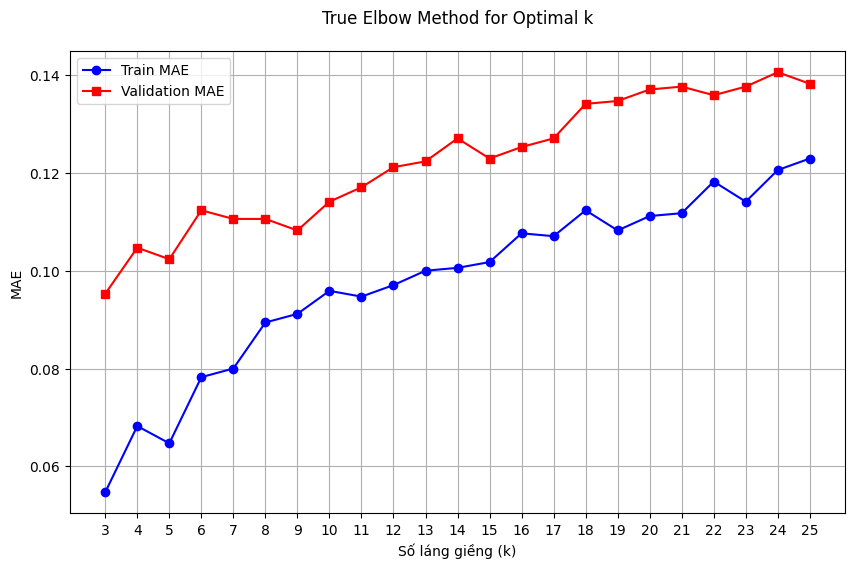

Điểm khuỷu tay tại k = 3

KNN với k=3
MAE trên tập test: 0.131

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.95      0.94       332
     Suspect       0.64      0.58      0.61        59
  Pathologic       0.83      0.71      0.77        35

    accuracy                           0.88       426
   macro avg       0.80      0.75      0.77       426
weighted avg       0.88      0.88      0.88       426

Confusion Matrix:
[[317  13   2]
 [ 22  34   3]
 [  4   6  25]]
Training with split ratio 70:30

KNN with original data


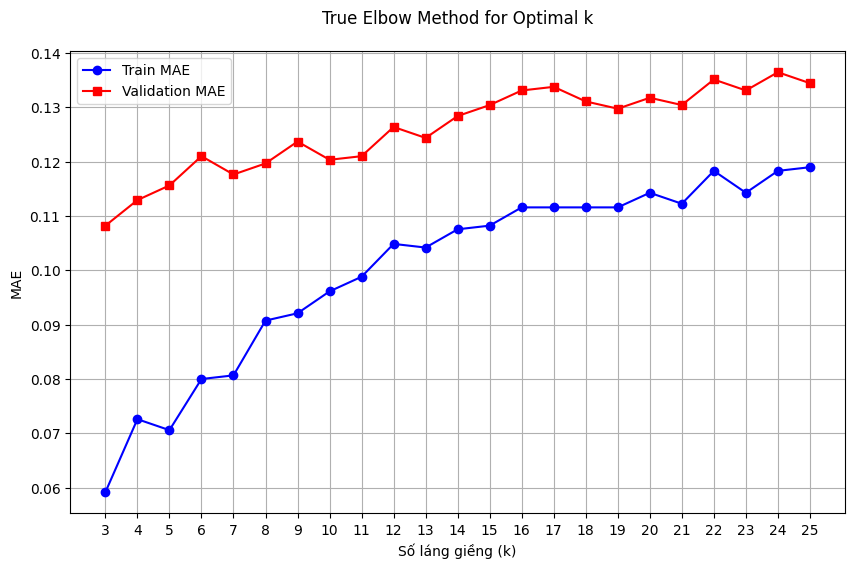

Điểm khuỷu tay tại k = 3

KNN với k=3
MAE trên tập test: 0.124

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.96      0.94       497
     Suspect       0.65      0.60      0.63        88
  Pathologic       0.90      0.68      0.77        53

    accuracy                           0.89       638
   macro avg       0.83      0.75      0.78       638
weighted avg       0.89      0.89      0.89       638

Confusion Matrix:
[[478  17   2]
 [ 33  53   2]
 [  6  11  36]]
Training with split ratio 60:40

KNN with original data


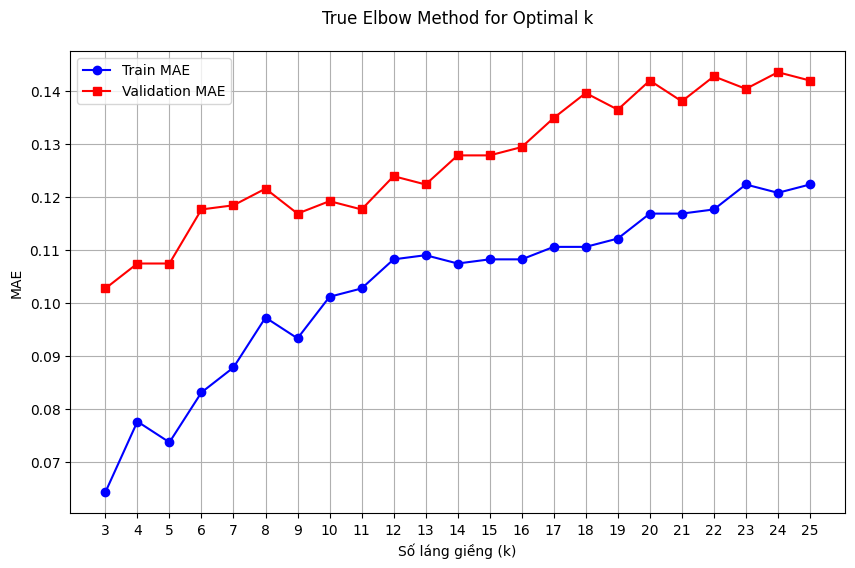

Điểm khuỷu tay tại k = 3

KNN với k=3
MAE trên tập test: 0.122

Classification Report:
              precision    recall  f1-score   support

      Normal       0.92      0.97      0.94       663
     Suspect       0.69      0.56      0.62       118
  Pathologic       0.89      0.71      0.79        70

    accuracy                           0.89       851
   macro avg       0.83      0.75      0.78       851
weighted avg       0.88      0.89      0.89       851

Confusion Matrix:
[[642  19   2]
 [ 48  66   4]
 [  9  11  50]]


In [6]:
split_ratios = [0.2, 0.3, 0.4]
for ratio in split_ratios:
    # Chia dữ liệu
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=ratio, random_state=42, stratify=y)
    print(f"Training with split ratio {int((1-ratio)*100)}:{int(ratio*100)}")
    
    # Tìm k tối ưu cho dữ liệu gốc
    print("\nKNN with original data")
    best_k = find_best_k_elbow(X_train, y_train)
    knn_model(X_train, X_test, y_train, y_test, k=best_k)
    

In [7]:
def evaluate_knn(X_train, X_test, y_train, y_test, k=5):
    model = KNeighborsClassifier(n_neighbors=k, metric='euclidean')
    model.fit(X_train, y_train)
    
    # Dự đoán trên tập train và test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Đánh giá trên tập train
    print("\nĐánh giá trên TẬP TRAIN (k=5):")
    print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.3f}")
    print("Classification Report:")
    print(classification_report(y_train, y_train_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_train, y_train_pred))
    
    # Đánh giá trên tập test
    print("\nĐánh giá trên TẬP TEST (k=5):")
    print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.3f}")
    print("Classification Report:")
    print(classification_report(y_test, y_test_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_test_pred))


## **Dữ liệu gốc**

In [8]:
# Thử nghiệm với tỷ lệ 80:20
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
evaluate_knn(X_train, X_test, y_train, y_test, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.065
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.99      0.97      1323
         2.0       0.85      0.76      0.80       236
         3.0       0.99      0.82      0.89       141

    accuracy                           0.94      1700
   macro avg       0.93      0.85      0.89      1700
weighted avg       0.94      0.94      0.94      1700

Confusion Matrix:
[[1307   16    0]
 [  56  179    1]
 [  11   15  115]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.134
Classification Report:
              precision    recall  f1-score   support

         1.0       0.91      0.97      0.94       332
         2.0       0.67      0.53      0.59        59
         3.0       0.83      0.69      0.75        35

    accuracy                           0.88       426
   macro avg       0.81      0.73      0.76       426
weighted avg       0.87      0.88      0.88       426

Confusion Matrix:
[[321   9   2]
 

In [9]:
# Thử nghiệm với tỷ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
evaluate_knn(X_train, X_test, y_train, y_test, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.071
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.97      1158
         2.0       0.83      0.74      0.78       207
         3.0       0.99      0.81      0.89       123

    accuracy                           0.94      1488
   macro avg       0.92      0.85      0.88      1488
weighted avg       0.94      0.94      0.93      1488

Confusion Matrix:
[[1139   19    0]
 [  52  154    1]
 [  10   13  100]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.144
Classification Report:
              precision    recall  f1-score   support

         1.0       0.91      0.96      0.93       497
         2.0       0.60      0.53      0.57        88
         3.0       0.89      0.60      0.72        53

    accuracy                           0.87       638
   macro avg       0.80      0.70      0.74       638
weighted avg       0.87      0.87      0.87       638

Confusion Matrix:
[[477  19   1]
 

In [10]:
# Thử nghiệm với tỷ lệ 60:40
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4, random_state=42, stratify=y)
evaluate_knn(X_train, X_test, y_train, y_test, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.074
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.99      0.97       992
         2.0       0.85      0.72      0.78       177
         3.0       0.98      0.78      0.87       106

    accuracy                           0.93      1275
   macro avg       0.92      0.83      0.87      1275
weighted avg       0.93      0.93      0.93      1275

Confusion Matrix:
[[981  11   0]
 [ 47 128   2]
 [ 11  12  83]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.137
Classification Report:
              precision    recall  f1-score   support

         1.0       0.91      0.97      0.94       663
         2.0       0.67      0.52      0.58       118
         3.0       0.88      0.63      0.73        70

    accuracy                           0.88       851
   macro avg       0.82      0.71      0.75       851
weighted avg       0.87      0.88      0.87       851

Confusion Matrix:
[[644  18   1]
 [ 52  61 

## **Dữ liệu PCA**

In [11]:
# Thử nghiệm với tỷ lệ 80:20
train_path = r'..\..\data\dimension_reduction\pca\train_80_20.csv'
test_path = r'..\..\data\dimension_reduction\pca\test_80_20.csv'

train_data_80 = pd.read_csv(train_path)
test_data_80 = pd.read_csv(test_path)

# Tách X và y
X_train_pca_80 = train_data_80.drop('Target', axis=1)
y_train_pca_80 = train_data_80['Target']

X_test_pca_80 = test_data_80.drop('Target', axis=1)
y_test_pca_80 = test_data_80['Target']
evaluate_knn(X_train_pca_80, X_test_pca_80, y_train_pca_80, y_test_pca_80, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.079
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.98      0.96      1322
         2.0       0.82      0.72      0.76       231
         3.0       0.92      0.83      0.87       147

    accuracy                           0.93      1700
   macro avg       0.90      0.84      0.87      1700
weighted avg       0.93      0.93      0.93      1700

Confusion Matrix:
[[1294   26    2]
 [  57  166    8]
 [  14   11  122]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.089
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       333
         2.0       0.78      0.66      0.71        64
         3.0       0.85      0.79      0.82        29

    accuracy                           0.92       426
   macro avg       0.86      0.81      0.83       426
weighted avg       0.91      0.92      0.91       426

Confusion Matrix:
[[325   8   0]
 

In [12]:
# Thử nghiệm với tỷ lệ 70:30
train_path = r'..\..\data\dimension_reduction\pca\train_70_30.csv'
test_path = r'..\..\data\dimension_reduction\pca\test_70_30.csv'

train_data_70 = pd.read_csv(train_path)
test_data_70 = pd.read_csv(test_path)

# Tách X và y
X_train_pca_70 = train_data_70.drop('Target', axis=1)
y_train_pca_70 = train_data_70['Target']

X_test_pca_70 = test_data_70.drop('Target', axis=1)
y_test_pca_70 = test_data_70['Target']
evaluate_knn(X_train_pca_70, X_test_pca_70, y_train_pca_70, y_test_pca_70, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.085
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96      1159
         2.0       0.81      0.68      0.74       194
         3.0       0.92      0.81      0.86       135

    accuracy                           0.93      1488
   macro avg       0.89      0.82      0.85      1488
weighted avg       0.92      0.93      0.92      1488

Confusion Matrix:
[[1137   20    2]
 [  55  131    8]
 [  14   11  110]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.102
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95       496
         2.0       0.77      0.68      0.72       101
         3.0       0.82      0.76      0.78        41

    accuracy                           0.91       638
   macro avg       0.84      0.80      0.82       638
weighted avg       0.90      0.91      0.91       638

Confusion Matrix:
[[479  17   0]
 

In [13]:
# Thử nghiệm với tỷ lệ 60:40
train_path = r'..\..\data\dimension_reduction\pca\train_60_40.csv'
test_path = r'..\..\data\dimension_reduction\pca\test_60_40.csv'

train_data_60 = pd.read_csv(train_path)
test_data_60 = pd.read_csv(test_path)

# Tách X và y
X_train_pca_60 = train_data_60.drop('Target', axis=1)
y_train_pca_60 = train_data_60['Target']

X_test_pca_60 = test_data_60.drop('Target', axis=1)
y_test_pca_60 = test_data_60['Target']
evaluate_knn(X_train_pca_60, X_test_pca_60, y_train_pca_60, y_test_pca_60, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.084
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.98      0.96       982
         2.0       0.80      0.70      0.75       175
         3.0       0.94      0.81      0.87       118

    accuracy                           0.93      1275
   macro avg       0.90      0.83      0.86      1275
weighted avg       0.92      0.93      0.92      1275

Confusion Matrix:
[[962  19   1]
 [ 48 122   5]
 [ 11  11  96]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.107
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95       673
         2.0       0.72      0.64      0.68       120
         3.0       0.81      0.76      0.79        58

    accuracy                           0.90       851
   macro avg       0.82      0.79      0.80       851
weighted avg       0.90      0.90      0.90       851

Confusion Matrix:
[[648  25   0]
 [ 33  77 

## **Dữ liệu LDA**

In [14]:
# Thử nghiệm với tỷ lệ 80:20
train_path = r'..\..\data\dimension_reduction\lda\train_80_20.csv'
test_path = r'..\..\data\dimension_reduction\lda\test_80_20.csv'

train_data_80 = pd.read_csv(train_path)
test_data_80 = pd.read_csv(test_path)

# Tách X và y
X_train_lda_80 = train_data_80.drop('Target', axis=1)
y_train_lda_80 = train_data_80['Target']

X_test_lda_80 = test_data_80.drop('Target', axis=1)
y_test_lda_80 = test_data_80['Target']
evaluate_knn(X_train_lda_80, X_test_lda_80, y_train_lda_80, y_test_lda_80, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.095
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.96      1322
         2.0       0.74      0.71      0.73       231
         3.0       0.90      0.80      0.85       147

    accuracy                           0.92      1700
   macro avg       0.86      0.83      0.84      1700
weighted avg       0.91      0.92      0.92      1700

Confusion Matrix:
[[1275   42    5]
 [  58  165    8]
 [  14   15  118]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.143
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.93      0.93       333
         2.0       0.62      0.61      0.61        64
         3.0       0.70      0.79      0.74        29

    accuracy                           0.87       426
   macro avg       0.75      0.78      0.76       426
weighted avg       0.87      0.87      0.87       426

Confusion Matrix:
[[309  20   4]
 

In [15]:
# Thử nghiệm với tỷ lệ 70:30
train_path = r'..\..\data\dimension_reduction\lda\train_70_30.csv'
test_path = r'..\..\data\dimension_reduction\lda\test_70_30.csv'

train_data_70 = pd.read_csv(train_path)
test_data_70 = pd.read_csv(test_path)

# Tách X và y
X_train_lda_70 = train_data_70.drop('Target', axis=1)
y_train_lda_70 = train_data_70['Target']

X_test_lda_70 = test_data_70.drop('Target', axis=1)
y_test_lda_70 = test_data_70['Target']
evaluate_knn(X_train_lda_70, X_test_lda_70, y_train_lda_70, y_test_lda_70, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.097
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.96      0.95      1159
         2.0       0.73      0.69      0.71       194
         3.0       0.90      0.82      0.86       135

    accuracy                           0.91      1488
   macro avg       0.86      0.82      0.84      1488
weighted avg       0.91      0.91      0.91      1488

Confusion Matrix:
[[1117   38    4]
 [  53  133    8]
 [  13   11  111]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.122
Classification Report:
              precision    recall  f1-score   support

         1.0       0.94      0.94      0.94       496
         2.0       0.70      0.67      0.69       101
         3.0       0.74      0.78      0.76        41

    accuracy                           0.89       638
   macro avg       0.79      0.80      0.80       638
weighted avg       0.89      0.89      0.89       638

Confusion Matrix:
[[468  25   3]
 

In [16]:
# Thử nghiệm với tỷ lệ 60:40
train_path = r'..\..\data\dimension_reduction\lda\train_60_40.csv'
test_path = r'..\..\data\dimension_reduction\lda\test_60_40.csv'

train_data_60 = pd.read_csv(train_path)
test_data_60 = pd.read_csv(test_path)

# Tách X và y
X_train_lda_60 = train_data_60.drop('Target', axis=1)
y_train_lda_60 = train_data_60['Target']

X_test_lda_60 = test_data_60.drop('Target', axis=1)
y_test_lda_60 = test_data_60['Target']
evaluate_knn(X_train_lda_60, X_test_lda_60, y_train_lda_60, y_test_lda_60, k=5)


Đánh giá trên TẬP TRAIN (k=5):
MAE: 0.102
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.96      0.95       982
         2.0       0.70      0.70      0.70       175
         3.0       0.89      0.77      0.83       118

    accuracy                           0.91      1275
   macro avg       0.85      0.81      0.83      1275
weighted avg       0.91      0.91      0.91      1275

Confusion Matrix:
[[944  35   3]
 [ 44 123   8]
 [ 10  17  91]]

Đánh giá trên TẬP TEST (k=5):
MAE: 0.136
Classification Report:
              precision    recall  f1-score   support

         1.0       0.95      0.93      0.94       673
         2.0       0.64      0.68      0.66       120
         3.0       0.71      0.79      0.75        58

    accuracy                           0.88       851
   macro avg       0.77      0.80      0.78       851
weighted avg       0.89      0.88      0.88       851

Confusion Matrix:
[[623  40  10]
 [ 29  82 

In [17]:
!pip list | grep mord

'grep' is not recognized as an internal or external command,
operable program or batch file.


In [18]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report

# Load dữ liệu
df = pd.read_csv("../../data/data_processed/data_processed.csv")
X = df.drop(columns=["NSP"]).values
y = df["NSP"].values  # 1:Normal, 2:Suspect, 3:Pathologic

# Chuẩn hóa dữ liệu (bắt buộc với SVM)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Định nghĩa trọng số phạt theo khoảng cách thứ tự
class_weights = {
    1: 1,  # Normal
    2: 2,  # Phạt nặng hơn nếu nhầm Normal -> Suspect
    3: 3   # Phạt rất nặng nếu nhầm Normal -> Pathologic
}

# Hàm đánh giá
def evaluate_svm(X_train, X_test, y_train, y_test, ratio_name):
    model = SVC(
        kernel='rbf',
        C=1.0,  # Tham số regularization
        class_weight=class_weights,
        decision_function_shape='ovr',
        random_state=42
    )
    model.fit(X_train, y_train)
    
    # Dự đoán
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Đánh giá
    print(f"\n{'='*60}\nTỉ lệ {ratio_name}\n{'='*60}")
    
    print("\nTẬP TRAIN:")
    print(f"- MAE: {mean_absolute_error(y_train, y_pred_train):.3f}")
    print("- Classification Report:")
    print(classification_report(y_train, y_pred_train, target_names=['Normal', 'Suspect', 'Pathologic']))
    
    print("\nTẬP TEST:")
    print(f"- MAE: {mean_absolute_error(y_test, y_pred_test):.3f}")
    print("- Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Suspect', 'Pathologic']))

# Thử nghiệm 3 tỉ lệ
ratios = {'4:1': 0.2, '7:3': 0.3, '6:4': 0.4}
for name, test_size in ratios.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, 
        test_size=test_size, 
        random_state=42, 
        stratify=y
    )
    evaluate_svm(X_train, X_test, y_train, y_test, name)


Tỉ lệ 4:1

TẬP TRAIN:
- MAE: 0.058
- Classification Report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97      1323
     Suspect       0.74      0.92      0.82       236
  Pathologic       0.98      0.90      0.94       141

    accuracy                           0.94      1700
   macro avg       0.90      0.92      0.91      1700
weighted avg       0.95      0.94      0.95      1700


TẬP TEST:
- MAE: 0.113
- Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.92      0.95       332
     Suspect       0.62      0.85      0.71        59
  Pathologic       0.86      0.71      0.78        35

    accuracy                           0.90       426
   macro avg       0.82      0.83      0.81       426
weighted avg       0.91      0.90      0.90       426


Tỉ lệ 7:3

TẬP TRAIN:
- MAE: 0.060
- Classification Report:
              precision    recall  f1-score   support

      Normal